# Hyperlattice Queuing Model

### Environment Setup

In [ ]:
import sys
import math
import numpy as np

from itertools import combinations, product

### Model

In [ ]:
class HyperlatticeQ(object):
    """
    Hyperlattice Queuing Model with Infinite-line Capacity

    A generalized hypercube queuing model, called Hyperlattice, that captures 
    the dynamics of emergency response operations with overlapping patrol. The 
    system state depends on the status of all the servers in this system, and 
    the number of calls in each queue to be processed. These states can be 
    represented by a hyperlattice in dimension I. Each node of the hyperlattice 
    corresponds to a state B = (ni)_{i in set_I} represented by a tuple of 
    numbers, where non-negative integer ni indicates the status of server i. 
    Server i is idle if ni = 0 and busy if ni > 0. The value of ni - 1 
    represents the number of calls waiting in the queue of server i when the 
    server is busy. 
    
    We note that the queuing system in the aggregate is simply a birth-death 
    process whose states are represented by Nk, where k=0,1,...,infinity. This 
    equivalence is obtained by collecting together all states having equal value
    of k = \norm{B}_1. Their summed probability of occurrence is equal to the 
    comparable probability of state occurring in the birth-death model. 
    """

    def __init__(self, I, A, Lam, Eta, mu, K=5, inf=30):
        """
        Params:
        * I:    number of servers (service regions)
        * A:    adjacent matrix that describes the overlappings between service 
                regions. If two regions has an overlapping area, the 
                corresponding entry equals to 1, otherwise 0. 
        * Lam:  arrival rates of each sub-regions, which has the same shape as 
                the adjacent matrix A. The values on the diagonal (i, i)  
                indicate the arrival rates of primary service regions and values 
                on the off-diagonal (i, j) and i != j indicates the arrival 
                rates of overlapping service regions. 
        * Eta:  dispatch probability when both servers are available or busy, 
                which has the same shape as the adjacent matrix A. The value of 
                entry (i, j) represents the probability of assigning call to 
                server i in the overlapping region (i, j). 
                Note that Eta_ij + Eta_ji = 1. 
        * mu:   service rate
        * K:    number of aggregated states to be truncated (estimated)
        * inf:  the maximum length of the queue considered in the model.
                Note that inf >> K is required. 
        """
        # hyperparameters
        self.I = I
        self.K = K
        self.A = A                                                     
        self.n_est_states = sum([ math.comb(I+k-1,I-1) for k in range(K+1) ])   # number of states in the truncated hyperlattice (need to be estimated through solving balance equations)
        self.set_B        = self._tour(K)                                       # set of states in the truncated hyperlattice
        # model parameters
        self.mu     = mu                                                        # constant service rate
        self.Lam    = Lam                                                       # arrival rates
        self.Eta    = Eta                                                       # dispatch policy
        self.Q      = self._transition_rates()                                  # transition rate matrix
        self.sumLam = np.triu(self.Lam).sum()                                   # sum of arrival rates of the entire service system
        self.aggLam = self._aggregated_arrival_rates(inf + 1)                   # aggregated arrival rates (bar_Lam_k)
        self.aggMu  = np.array([ mu * I ** (k+1) for k in range(inf + 1) ])     # aggregated service rates (bar_mu_k)  
        # steady-state distribution
        self.Pi_N   = self._birth_death_solver(inf)                             # steady state probabilities of aggregated states (Nk)
        self.Pi_B   = self._balance_equations_solver()                          # steady state probabilities of states in the truncated hyperlattice (Bu)
        # performance metrics

    def _tour(self, K):
        """
        Tour Algorithm

        The construction of the transition rate matrix requires a complete tour 
        of all the states in the hyperlattice. The tour algorithm generates a 
        complete sequence B_0, B_1, ... of I-digit non-negative integer numbers, 
        with infinite members in the sequence.
        """
        def binary2states(I, bvec):                                             # translate binary combinatorics into state (a vector of non-negative integers)
            B = np.zeros(I)                                                     # initialization of state
            i = 0                                                               # server index
            for b in bvec:
                if b == 1:
                    B[i] += 1                                                   # n_i + 1 if the "ball" is selected
                else:
                    i += 1                                                      # otherwise move to the next ball
            return B

        # initialization
        u     = 0                                                               # state index
        nB    = sum([ math.comb(self.I+k-1,self.I-1) for k in range(K+1) ])     # number of states in the tour
        set_B = np.zeros((nB, self.I))                                          # set of states in the truncated hyperlattice
        # tour starting from N0 to NK
        for k in range(K+1):
            combs = combinations(np.arange(k+self.I-1), k)                      # separate k stars (using I-1 bars) into I groups
            for comb in combs:
                bvec             = np.zeros(k+self.I-1)                         # combinatorics
                bvec[list(comb)] = 1
                set_B[u]         = binary2states(self.I, bvec)                  # state
                u               += 1
        return set_B                                                            # set of all states with shape [ n_est_states, I ]

    def __q(self, Bu, Bv):
        """
        Return the Transition Rate Between State Bu and Bv
        """
        quv  = 0
        dvec = Bu - Bv
        if np.linalg.norm(dvec, ord=1) == 1 and sum(dvec) > 0:                  # downward transition rate
            quv     = self.mu
        elif np.linalg.norm(dvec, ord=1) == 1 and sum(dvec) < 0:                # upward transition rate
            i       = np.where(dvec == -1)[0][0]                                # index of the state becoming busy
            ni0nj0  = [ j                                                       # indices of states j when both i and j are available (ni = nj = 0)
                for j in range(self.I) 
                if self.A[i,j] == 1 and \
                    Bu[i] == 0 and Bu[j] == 0 ]
            ninj    = [ j                                                       # indices of states j when both i and j are busy (ni, nj > 0)
                for j in range(self.I) 
                if self.A[i,j] == 1 and \
                    Bu[i] > 0 and Bu[j] > 0 ]
            ni0nj   = [ j                                                       # indices of states j when i is available and j is busy (ni = 0, nj > 0)
                for j in range(self.I) 
                if self.A[i,j] == 1 and \
                    Bu[i] == 0 and Bu[j] > 0 ]
            quv = self.Lam[i, i] + \
                sum([ self.Eta[i,j] * self.Lam[i,j] for j in ni0nj0 ]) + \
                sum([ self.Eta[i,j] * self.Lam[i, j] for j in ninj ]) + \
                sum([ self.Lam[i, j] for j in ni0nj ])
        else:
            quv = 0.
        return quv
    
    def _transition_rates(self):
        """
        Generate Transition Rate Matrix
        """
        # initialization of transition rate matrix
        Q = np.zeros((self.n_est_states, self.n_est_states))                    
        # fill in off-diagonal entries
        for u in range(self.n_est_states):
            for v in range(self.n_est_states):
                Q[u, v] = self.__q(self.set_B[u], self.set_B[v])                # transition rate between state Bu and Bv
        # fill in diagonal entries
        for u in range(self.n_est_states):
            Q[u, u] = - Q[u, :].sum()                                           # so that each row sums to 0
        return Q                                                                # transition rate matrix with shape [ n_est_states, n_est_states ]

    def _aggregated_arrival_rates(self, inf):
        """
        Arrival Rates for Aggregated States Nk

        TODO:
        Optimize the calculation of aggregated arrival rates. 
        """
        # find state indices for each aggregated group
        ids     = []                                                            
        init_id = 0
        for k in range(inf + 1):
            idk     = np.arange(math.comb(self.I+k-1, self.I-1)) + init_id      # ids[k] gives state indices within the aggregated state k
            init_id = idk[-1] + 1
            ids.append(idk)
        # calculate sum of arrival rates between two consecutive groups
        set_B  = self._tour(inf)                                                # set of all the states 
        aggLam = []
        for k in range(inf):
            agglam = 0
            for uk, uk1 in product(ids[k], ids[k+1]):                           # for a state (uk) from Nk and another state (uk1) from Nk+1
                qukuk1 = self.__q(set_B[uk], set_B[uk1])                        # this step is computationally intensive
                if qukuk1 > 0:
                    agglam += qukuk1
            aggLam.append(agglam)

        return np.array(aggLam)
    
    def _birth_death_solver(self, inf):
        """
        Birth-Death Model Solver 

        This function calculates steady state probabilities for aggregated 
        states in a birth-death model. 
        """
        C    = np.array([                                                       # C0 = 1
            1 if k == 0 \
            else np.prod([ self.aggLam[n]/self.aggMu[n+1] for n in range(k) ])  # Ck = ( lam_0 * ... * lam_k-1 ) / ( mu_1 * ... * mu_k )
            for k in range(inf) ])
        Pi_N = np.array([                                                       # P0 = 1 / ( sum_k=1^inf Ck )
            1 / C.sum() if k == 0 else C[k] / C.sum()                           # Pk = C_k / ( sum_k=1^inf Ck )
            for k in range(inf) ])
        return Pi_N

    def _balance_equations_solver(self):
        """
        Solve Balance Equations by Matrix Inversion

        This function calculates steady state probabilities for states in the 
        truncated hyperlattice.

        Reference: 
        Constructing and Solving Markov Processes, Section 3.3.2
        https://homepages.inf.ed.ac.uk/jeh/biss2013/Note3.pdf

        TODO: 
        Implement power method to solve balance equations more efficiently, 
        especially when I is large. 
        """
        sum_Pi   = self.Pi_N[:self.K+1].sum()
        Q        = self.Q.copy()                                                # create a copy of transition rate matrix
        Q[:, -1] = np.ones(self.n_est_states)                                   # replace the last column with a vector of 1's
        en       = np.zeros(self.n_est_states)                                  # initialize “solution” vector, which was all zeros to be a column vector with 1 in the last row, and zeros everywhere else
        en[-1]   = sum_Pi
        invQ     = np.linalg.inv(Q.transpose())                                 # inverse of matrix Q
        Pi       = np.matmul(invQ, en)                                          # Pi = (Q^T)^{-1} * en
        return Pi

if __name__ == "__main__":

    A2 = np.array([
        [0, 1],
        [1, 0]
    ])
    Lam2 = np.array([
        [.4, .2], 
        [.2, .4]
    ])
    Eta2 = np.array([
        [0, 0.5],
        [0.5, 0]
    ])

    A3 = np.array([
        [0, 1, 1],
        [1, 0, 1],
        [1, 1, 0]
    ])
    Lam3a = np.array([
        [.2, .1, .2], 
        [.1, .2, .1],
        [.2, .1, .2]
    ])
    Lam3b = np.array([
        [.05, .3, .15], 
        [.3, .05, .3],
        [.15, .3, .05]
    ])
    Eta3 = np.array([
        [0, 0.5, 0.5],
        [0.5, 0, 0.5],
        [0.5, 0.5, 0]
    ])

    print("I=2")
    hq = HyperlatticeQ(I=2, A=A2, Lam=Lam2, Eta=Eta2, mu=1, K=3)
    print(hq.set_B)
    print(hq.Pi_N)
    print(hq.Pi_N.sum())
    print(hq.Pi_N[:3+1].sum())
    print(hq.Pi_B.sum())

    # print("I=3")
    # hq = HyperlatticeQ(I=3, A=A3, Lam=Lam3b, Eta=Eta3, mu=2, K=3)
    # print(hq.set_B)
    # print(hq.Pi_N.sum())
    # print(hq.Pi_N)
    # print(hq.Pi_N[:3+1].sum())
    # print(hq.Pi_B.sum())

I=2
[[0. 0.]
 [1. 0.]
 [0. 1.]
 [2. 0.]
 [1. 1.]
 [0. 2.]
 [3. 0.]
 [2. 1.]
 [1. 2.]
 [0. 3.]]
[7.54259559e-001 1.88564890e-001 4.71412225e-002 8.83897921e-003
 1.10487240e-003 8.63181564e-005 4.04616358e-006 1.10637285e-007
 1.72870758e-009 1.51937190e-011 7.41880811e-014 1.99235569e-016
 2.91848978e-019 2.31569624e-022 9.89372173e-026 2.26449319e-029
 2.76427392e-033 1.79262759e-037 6.15449840e-042 1.11518354e-046
 1.06352190e-051 5.32483098e-057 1.39649250e-062 1.91446111e-068
 1.36932929e-074 5.10114912e-081 9.88169590e-088 9.93929018e-095
 5.18374378e-102 1.40004390e-109]
1.0
0.9988046508973623
0.9988046508973621


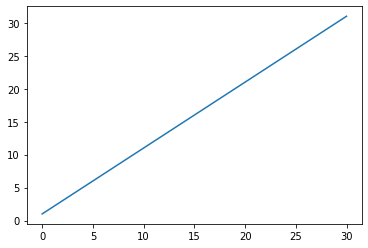

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = plt.axes()

Lam = hq.aggLam
x   = np.arange(len(Lam))
mu  = np.array([ hq.mu * hq.I ** (k+1) for k in range(len(Lam)) ]) 
ax.plot(x, Lam)
# ax.plot(x, mu)